### Import raw x-ray images of the test object and background

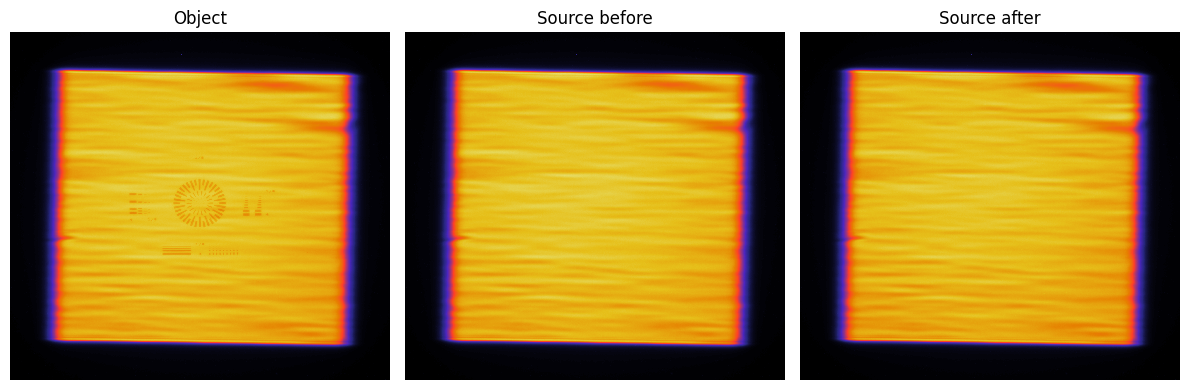

In [1]:
import numpy as np
import matplotlib.pyplot as plt

file = "siemens_new"

data_input_object = np.loadtxt(f"test_input/{file}/object.asc")[:, 1:].T
data_input_source_before = np.loadtxt(f"test_input/{file}/back_before.asc")[:, 1:].T
data_input_source_after = np.loadtxt(f"test_input/{file}/back_after.asc")[:, 1:].T

fig, ax = plt.subplots(1, 3, figsize=(12, 4))

ax[0].pcolormesh(data_input_object, cmap="CMRmap")
ax[0].axis("off")
ax[0].set_title("Object")

ax[1].pcolormesh(data_input_source_before, cmap="CMRmap")
ax[1].axis("off")
ax[1].set_title("Source before")

ax[2].pcolormesh(data_input_source_after, cmap="CMRmap")
ax[2].axis("off")
ax[2].set_title("Source after")

plt.tight_layout()
plt.show()

### Median filtering of dead pixels and rotating

In [2]:
def clean_xray_image_stack(image_stack, median_filter_size=3, threshold_factor=3):
  """
  Очищает стек рентгеновских изображений от аномальных выбросов (горячих пикселей).

  Args:
    image_stack: NumPy массив формы (21, 2048, 2048), представляющий стек рентгеновских изображений.
    median_filter_size: Размер ядра медианного фильтра. Нечетное число, определяющее размер окрестности
                        для вычисления медианного значения.  Типичные значения: 3, 5, 7.
    threshold_factor:  Фактор, определяющий порог для обнаружения выбросов.  Умножается на стандартное отклонение
                       окрестности пикселя.  Более высокое значение делает детектор выбросов менее чувствительным.

  Returns:
    NumPy массив той же формы, что и входной, с очищенными изображениями.
  """

  is_numpy = isinstance(image_stack, np.ndarray)
  xp = np if is_numpy else cp # Выбираем модуль: cupy или numpy
  if is_numpy:
      import scipy.ndimage as ndimage
  else:
      import cupyx.scipy.ndimage as ndimage

  cleaned_stack = xp.zeros_like(image_stack)

  for i in range(image_stack.shape[0]):  # Итерируемся по кадрам
    frame = image_stack[i]

    # 1. Медианный фильтр для начального обнаружения и оценки фона
    #    Медианный фильтр эффективно удаляет выбросы, сохраняя при этом структуру изображения.
    median_filtered = ndimage.median_filter(frame, size=median_filter_size)

    # 2. Вычисление разницы между оригинальным изображением и отфильтрованным
    difference = np.abs(frame - median_filtered)

    # 3. Вычисление стандартного отклонения разницы в окрестности каждого пикселя
    #    Используем фильтр стандартного отклонения.  Можно использовать `scipy.ndimage.generic_filter`
    #    с функцией, вычисляющей стандартное отклонение.  Для простоты можно использовать медианный фильтр
    #    разницы и затем умножить результат на оценочный коэффициент для стандартного отклонения.
    #    Медианный фильтр эффективно сглаживает разницу, обеспечивая оценку локального стандартного отклонения.
    #    Альтернативно, можно использовать свертку с ядром для оценки стандартного отклонения, но это
    #    требует более тщательной настройки параметров ядра.
    std_dev_estimate = ndimage.median_filter(difference, size=median_filter_size) * 1.4826  # 1.4826 приближает std при нормальном распределении

    # 4. Создание маски выбросов
    #    Пиксели, отклоняющиеся от медианного фильтра больше, чем threshold_factor * std_dev_estimate,
    #    считаются выбросами.
    outlier_mask = difference > (threshold_factor * std_dev_estimate)

    # 5. Замена выбросов медианными значениями
    #    Заменяем значения выбросов медианными значениями из отфильтрованного изображения.
    cleaned_frame = frame.copy()  # Создаем копию, чтобы не менять исходный кадр
    cleaned_frame[outlier_mask] = median_filtered[outlier_mask]

    cleaned_stack[i] = cleaned_frame

  return cleaned_stack

data_input_object_corrected = clean_xray_image_stack(data_input_object)
data_input_source_before_corrected = clean_xray_image_stack(data_input_source_before)
data_input_source_after_corrected = clean_xray_image_stack(data_input_source_after)

from scipy import ndimage
angle = 0.5
data_input_object_rotated = ndimage.rotate(data_input_object_corrected, angle, reshape=False, mode="nearest") 
data_input_source_before_rotated = ndimage.rotate(data_input_source_before_corrected, angle, reshape=False, mode="nearest")
data_input_source_after_rotated = ndimage.rotate(data_input_source_after_corrected, angle, reshape=False, mode="nearest") 

### Flat field correction

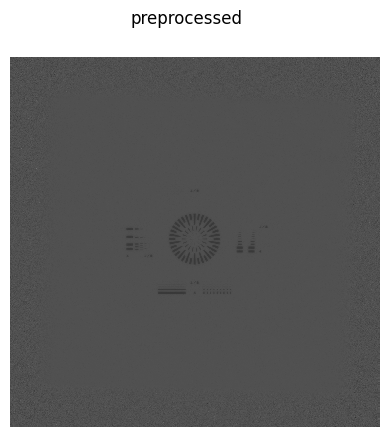

In [3]:
%matplotlib inline
obj_prepro = 2 * data_input_object_rotated / (data_input_source_before_rotated + data_input_source_after_rotated)
# obj_medfil_old = siemens_rotated_old / back_rotated_old
fig, ax = plt.subplots(1, 1)
ax.set_aspect('equal')
plt.pcolormesh(obj_prepro, cmap="Greys_r")
# colbar = plt.pcolormesh(x_input_test, y_input_test, data_input_test/np.max(data_input_test), cmap='Greys_r')
# cbar = fig.colorbar(colbar)
plt.axis("off")
fig.suptitle("preprocessed")
# plt.savefig(f"raw_data.png", bbox_inches='tight', pad_inches=0, dpi=400)
plt.show()

### ROI of the image

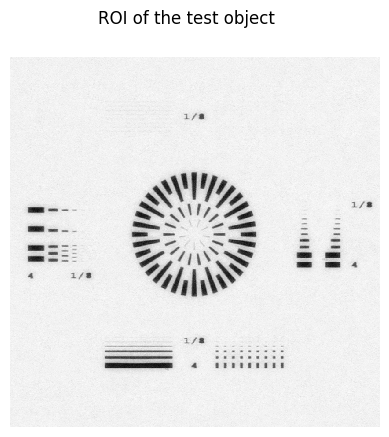

In [4]:
def cutter(image, center_x, center_y, idx_cut):
    data_input_test = image.copy()
    dx_input_test = 0.325
    dy_input_test = 0.325
    Nx, Ny = image.shape
    x_input_test = np.linspace(0, (Nx-1)*dx_input_test, Nx)
    y_input_test = np.linspace(0, (Ny-1)*dy_input_test, Ny)

    # center = 1024
    # idx_cut = 512

    x_input_test -= x_input_test[center_x]
    y_input_test -= y_input_test[center_y]

    x_input_test = x_input_test[center_x-idx_cut : center_x+idx_cut]
    y_input_test = y_input_test[center_y-idx_cut : center_y+idx_cut]
    data_input_test = data_input_test[center_y-idx_cut : center_y+idx_cut, center_x-idx_cut : center_x+idx_cut]

    # return x_input_test[1:], y_input_test[1:], data_input_test[1:, 1:]
    return x_input_test, y_input_test, data_input_test
    # return x_input_test[2:], y_input_test[2:], data_input_test[2:, 2:]
    # return x_input_test[1:-2], y_input_test[1:-2], data_input_test[1:-2, 1:-2]

x_cut, y_cut, obj_ROI = cutter(obj_prepro, 1024, 1024, 420)

# x_cut, y_cut, obj_med_cutted = cutter(obj_medfil, 1013, 503, 200)

# x_cut, y_cut, obj_med_cutted_old = cutter(obj_medfil_old, 1020, 1270, 450)
# x_cut, y_cut, obj_med_cutted_old = cutter(obj_medfil_old, 1040, 1000, 450)

# x_cut, y_cut, obj_med_cutted = cutter(obj_medfil, 1020, 1040, 180)
# x_cut, y_cut, obj_med_cutted_old = cutter(obj_medfil_old, 990, 1298, 180)
# x_cut, y_cut, obj_med_cutted_old = cutter(obj_medfil_old, 1020, 1040, 180)
%matplotlib inline
fig, ax = plt.subplots(1, 1)
ax.set_aspect('equal')
# plt.pcolormesh(obj_med_cutted, cmap="CMRmap_r")
# plt.pcolormesh(obj_med_cutted, cmap="Greys_r")
plt.pcolormesh(obj_ROI, cmap="Greys_r")
# colbar = plt.pcolormesh(x_input_test, y_input_test, data_input_test/np.max(data_input_test), cmap='Greys_r')
# cbar = fig.colorbar(colbar)
plt.axis("off")
fig.suptitle("ROI of the test object")
# plt.savefig(f"raw_data2.png", bbox_inches='tight', pad_inches=0, dpi=400)
plt.show()

### Distribution test

--- Параметры аппроксимации Гауссовой кривой ---
Амплитуда (A, фактор нормировки): 98.0855
Центр (mu):                      1.0010
Ширина (sigma, стандартное откл.):0.0035
Смещение (C, базовая линия):     0.9826
--------------------------------------------------
1.0010466041727601


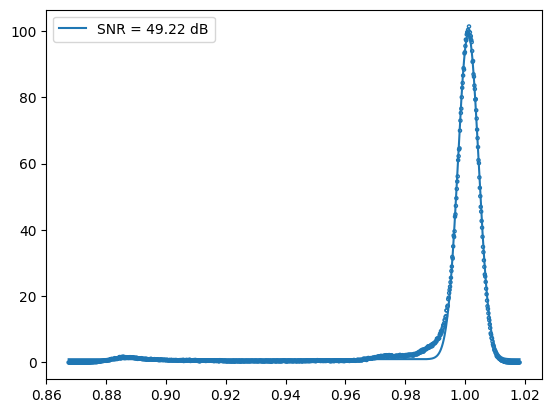

In [5]:
from scipy.optimize import curve_fit

bins_num = 1000

hist, bin_edges = np.histogram(obj_ROI, bins=bins_num, density=True)
bin_edges = (bin_edges[1:] + bin_edges[0:-1]) / 2
plt.scatter(bin_edges, hist, s=5, facecolors='none', edgecolors='C0')


def fit_gaussian(x_data, y_data):
    """
    Аппроксимирует одномерные данные (x_data, y_data) Гауссовой функцией.

    Модель Гаусса: f(x) = A * exp(-(x - mu)^2 / (2 * sigma^2)) + C
    Где:
    - A: Амплитуда (высота пика) Гауссовой кривой, также может рассматриваться как фактор нормировки.
    - mu: Центр (среднее значение) Гауссовой кривой.
    - sigma: Ширина (стандартное отклонение) Гауссовой кривой.
    - C: Смещение (базовая линия).

    Параметры:
    x_data : numpy.ndarray
        Одномерный массив значений по оси X.
    y_data : numpy.ndarray
        Одномерный массив значений по оси Y, соответствующий x_data.

    Возвращает:
    numpy.ndarray
        Массив значений Y, представляющий аппроксимированную Гауссову кривую
        для заданных x_data и найденных параметров.
        Возвращает None, если аппроксимация не удалась.
    """

    # 1. Определяем Гауссову функцию
    # Смещение (offset) добавляется для учета ненулевой базовой линии
    def gaussian(x, amplitude, center, sigma, offset):
        return amplitude * np.exp(-(x - center)**2 / (2 * sigma**2)) + offset

    # 2. Предоставляем начальные догадки для параметров
    # Хорошие начальные догадки помогают curve_fit быстрее и правильнее сойтись.
    amplitude_guess = np.max(y_data) - np.min(y_data) # Примерная амплитуда пика
    center_guess = x_data[np.argmax(y_data)]         # X-координата максимального Y
    sigma_guess = (x_data[-1] - x_data[0]) / 10.0     # Примерная ширина (диапазон / 6)
    offset_guess = np.min(y_data)                     # Примерная базовая линия

    initial_guesses = [amplitude_guess, center_guess, sigma_guess, offset_guess]

    # Ограничения для параметров (опционально, но часто полезно)
    # Например, sigma должна быть положительной, амплитуда может быть положительной/отрицательной
    # center_guess в пределах x_data, offset_guess в пределах y_data
    # bounds = ([min_amplitude, min_center, min_sigma, min_offset],
    #           [max_amplitude, max_center, max_sigma, max_offset])
    # Для sigma точно надо, чтобы была > 0
    bounds = ([-np.inf, x_data.min(), 0.001, -np.inf], # Нижние границы
              [ np.inf, x_data.max(), np.inf,  np.inf]) # Верхние границы


    # 3. Выполняем аппроксимацию
    try:
        # popt - оптимальные параметры, pcov - ковариационная матрица
        popt, pcov = curve_fit(gaussian, x_data, y_data, p0=initial_guesses, bounds=bounds)
    except RuntimeError as e:
        print(f"Ошибка при аппроксимации Гауссовой функцией: {e}")
        print("Попробуйте скорректировать начальные параметры или данные.")
        return None

    # 4. Извлекаем аппроксимированные параметры
    amplitude_fit, center_fit, sigma_fit, offset_fit = popt

    # 5. Выводим параметры через print
    print("--- Параметры аппроксимации Гауссовой кривой ---")
    print(f"Амплитуда (A, фактор нормировки): {amplitude_fit:.4f}")
    print(f"Центр (mu):                      {center_fit:.4f}")
    print(f"Ширина (sigma, стандартное откл.):{sigma_fit:.4f}")
    print(f"Смещение (C, базовая линия):     {offset_fit:.4f}")
    print("--------------------------------------------------")

    # 6. Генерируем аппроксимированную кривую
    fitted_gaussian_curve = gaussian(x_data, *popt)

    return center_fit, sigma_fit, fitted_gaussian_curve

mu, sig, hist_approx = fit_gaussian(bin_edges, hist)
print(mu)

def SNR(mu, sig):
    return 20 * np.log10(mu / sig)

%matplotlib inline
plt.plot(bin_edges, hist_approx, label=f"SNR = {SNR(mu, sig):.2f} dB")
# plt.xlim(0.98, 1.02)
plt.legend()

### Denoising (Noise2Self)

c:\Users\mamich\anaconda3\envs\aydin_env\lib\site-packages\dask\dataframe\__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


0:	learn: 0.0514551	test: 0.0528329	best: 0.0528329 (0)	total: 78.3ms	remaining: 5m 20s
50:	learn: 0.0155569	test: 0.0156203	best: 0.0156203 (50)	total: 484ms	remaining: 38.4s
100:	learn: 0.0152546	test: 0.0154773	best: 0.0154738 (95)	total: 943ms	remaining: 37.3s
bestTest = 0.01547384315
bestIteration = 95
Shrink model to first 96 iterations.
0:	learn: 0.0481556	test: 0.0493899	best: 0.0493899 (0)	total: 10.1ms	remaining: 41.3s
bestTest = 0.01782417255
bestIteration = 17
Shrink model to first 18 iterations.
0:	learn: 0.0497513	test: 0.0510972	best: 0.0510972 (0)	total: 10.2ms	remaining: 41.7s
50:	learn: 0.0153964	test: 0.0155571	best: 0.0155568 (47)	total: 449ms	remaining: 35.6s
bestTest = 0.01555678915
bestIteration = 47
Shrink model to first 48 iterations.
0:	learn: 0.0519675	test: 0.0533500	best: 0.0533500 (0)	total: 9.86ms	remaining: 40.4s
50:	learn: 0.0175357	test: 0.0176588	best: 0.0176588 (50)	total: 415ms	remaining: 32.9s
100:	learn: 0.0152867	test: 0.0154407	best: 0.0154407 (

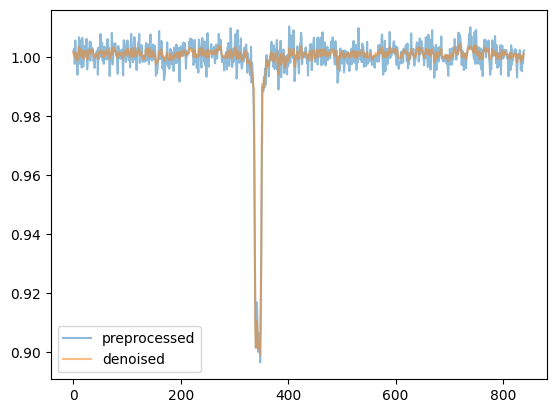

In [6]:
from aydin.restoration.denoise.noise2selffgr import noise2self_fgr
obj_denoised = noise2self_fgr(obj_ROI)

%matplotlib inline
idx = 180
plt.plot(obj_ROI[:, idx], alpha=0.5, label="preprocessed")
plt.plot(obj_denoised[:, idx], alpha=0.5, label="denoised")
plt.legend()

### Denoised image of the test object

Text(0.5, 0.98, 'denoised')

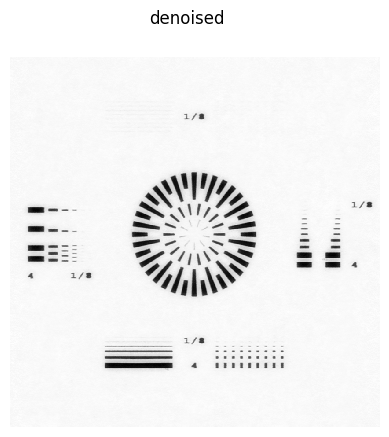

In [7]:
# %matplotlib tk
fig, ax = plt.subplots(1, 1)
# plt.pcolormesh(obj_denoised, cmap="CMRmap_r")
plt.pcolormesh(obj_denoised, cmap="Greys_r")
# plt.pcolormesh(obj_denoised_denoised, cmap="")
ax.set_aspect('equal')
plt.axis("off")
fig.suptitle("denoised")
# plt.savefig(f"denoised_color.png", bbox_inches='tight', pad_inches=0, dpi=400)

### Interpolation (optional)

Text(0.5, 0.98, 'interpolated')

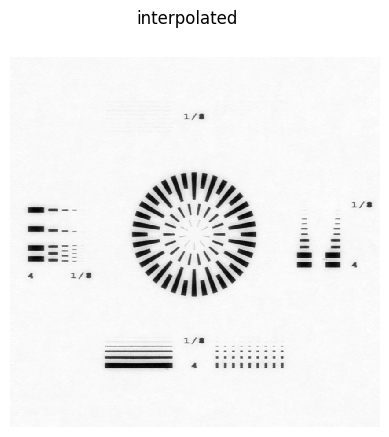

In [8]:
def interpolate_frames(image_stack, x, y, N_interp):
  """
  Проводит кубическую интерполяцию кадров cupy массива и увеличивает размер сетки.
  """
  is_numpy = isinstance(image_stack, np.ndarray)
  import scipy.ndimage as ndimage
  import scipy.interpolate as interpolate

  # Интерполируем каждый кадр стека.
  data_interp = np.zeros((N_interp, N_interp), dtype=image_stack.dtype)
  x_interp = np.linspace(x.min(), x.max(), N_interp)
  y_interp = np.linspace(y.min(), y.max(), N_interp)



  interp = interpolate.RegularGridInterpolator((x, y), image_stack, method="linear",
                                        bounds_error=False, fill_value=None)
    # data_interp[i] = interp(np.meshgrid(y_interp, x_interp, indexing="ij"))
  X, Y = np.meshgrid(x_interp, y_interp, indexing='ij')
  data_interp = interp((X, Y))

    # data_interp[i] = ndimage.zoom(image_stack[i], N_interp/len(x), order=3) # order=3 задает кубическую интерполяцию

  # Создаем новые массивы координат.

  # data_interp = cp.array(data_interp)


  return x_interp, y_interp, data_interp
%matplotlib inline

# x_interp, y_interp, obj_interp = interpolate_frames(image_stack=obj_denoised, x=x_cut, y=y_cut, N_interp=2**10)
x_interp, y_interp, obj_interp = x_cut, y_cut, obj_denoised

fig, ax = plt.subplots(1, 1)
# plt.pcolormesh(x_interp, y_interp, obj_interp, cmap="CMRmap_r")
plt.pcolormesh(x_interp, y_interp, obj_interp, cmap="Greys_r")
ax.set_aspect('equal')
plt.axis("off")
fig.suptitle("interpolated")
# plt.savefig(f"interp.png", bbox_inches='tight', pad_inches=0, dpi=400)

### Lucy-Richardson Deconvolution 

In [9]:
import cupy as cp

def OTF_func(fx, fy, a, b):
    fx, fy = np.meshgrid(fx, fy)
    f_rad = np.sqrt(fx**2 + fy**2)
    return np.exp(-a * (f_rad)**b)
    # return (0.01310693 / np.sin(np.sin(0.02833368 ** (np.log1p(f_rad) + -0.49189684)) + 7.5945916)) ** f_rad

def OTF_source(fx, fy, a, b):
    fx, fy = np.meshgrid(fx, fy)
    f_rad = np.sqrt(fx**2+fy**2) * 2 * np.pi

    sig_x = 2.0410474168435953e-01
    sig_y = 2.318471337579618e-02 
    
    return np.exp(- a*(f_rad)**b) * np.exp(- 0.5 * ((fx*sig_x)**2)+(fy*sig_y)**2)

from cupy.fft import fft2, ifft2

def LRA(image, OTF, iter=None, df=None):

    f = cp.ones(image.shape) * 0.5

    if iter != None and df == None:
        for i in range(iter):
            f0 = f.copy()
            ratt = image / (ifft2(OTF * fft2(f)).real + 1e-12)
            f *= ifft2(OTF * fft2(ratt)).real

            stp = np.sum(abs(f0-f))/np.sum(f)
            if (i+1)%(iter//2) == 0:
                print(f"i = {i}, df/f = {stp:1.4}")
    else:
        i = 0
        stp = df + 1
        while stp >= df and i < 500:
            f0 = f.copy()
            ratt = image / (ifft2(OTF * fft2(f)).real + 1e-12)
            f *= ifft2(OTF * fft2(ratt)).real

            stp = np.sum(abs(f0-f))/np.sum(f)
            if i%20 == 0:
                print(f"i = {i}, df/f = {stp:1.4}")
            i += 1
        print(f"i = {i}, df/f = {stp:1.4}")
    return f

V = 200
obj_padded = np.pad(obj_interp, ((V, V), (V, V)), 'edge')

# dx = x_interp[1] - x_interp[0]
# dy = y_interp[1] - y_interp[1]

dx = 0.325
dy = 0.325

fy = np.fft.fftfreq(obj_padded.shape[0], dy)
fx = np.fft.fftfreq(obj_padded.shape[1], dx)

# OTF = cp.array(OTF_func(fx, fy, 0.7120983, 1.00979984))
# OTF = cp.array(OTF_func(fx, fy, 0.62461355, 1.17612002))
OTF = cp.array(OTF_func(fx, fy, 4.05282672, 1.02456784))


# OTF = cp.array(OTF_mcdon(fx, fy, 0.8))
# OTF = cp.array(OTF_func(fx, fy, 0.75,  1.00979984))
# OTF = cp.array(OTF_source(fx, fy, 0.7120983, 1.00979984))

# alpha1, beta1, iterat = 0, 1, 12

alpha1, beta1, iterat = 0.5, 1, 50

# obj_deconv = LRRA(cp.array(obj_padded), OTF, alpha1=alpha1, beta1=beta1, iterations=iterat).get()[V:-V, V:-V]
obj_deconv = LRA(cp.array(obj_padded), OTF, df=2e-5).get()[V:-V, V:-V]

i = 0, df/f = 0.4991
i = 20, df/f = 9.516e-05
i = 40, df/f = 5.673e-05
i = 60, df/f = 4.141e-05
i = 80, df/f = 3.326e-05
i = 100, df/f = 2.817e-05
i = 120, df/f = 2.466e-05
i = 140, df/f = 2.206e-05
i = 160, df/f = 2.004e-05
i = 162, df/f = 1.996e-05


### Deconvolved image

Text(0.5, 0.98, 'deconvolved')

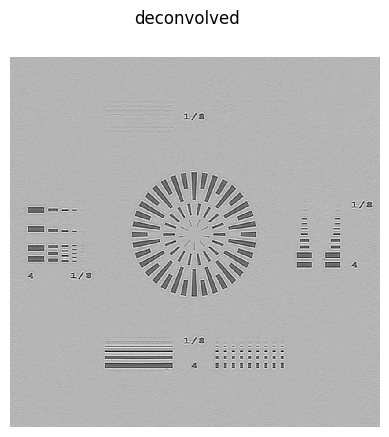

In [10]:
%matplotlib inline
fig, ax = plt.subplots(1, 1)
# plt.pcolormesh(obj_deconv, cmap="CMRmap")
plt.pcolormesh(obj_deconv, cmap="Greys_r")
ax.set_aspect('equal')
plt.axis("off")
fig.suptitle("deconvolved")
# plt.savefig(f"deconv.png", bbox_inches='tight', pad_inches=0, dpi=400)

### SNR & CNR estimation

--- Параметры аппроксимации Гауссовой кривой ---
Амплитуда (A, фактор нормировки): 98.0855
Центр (mu):                      1.0010
Ширина (sigma, стандартное откл.):0.0035
Смещение (C, базовая линия):     0.9826
--------------------------------------------------
1.001046604141848
--- Параметры аппроксимации Гауссовой кривой ---
Амплитуда (A, фактор нормировки): 213.4820
Центр (mu):                      1.0013
Ширина (sigma, стандартное откл.):0.0015
Смещение (C, базовая линия):     1.3544
--------------------------------------------------
--- Параметры аппроксимации Гауссовой кривой ---
Амплитуда (A, фактор нормировки): 64.2556
Центр (mu):                      1.0016
Ширина (sigma, стандартное откл.):0.0054
Смещение (C, базовая линия):     0.2432
--------------------------------------------------


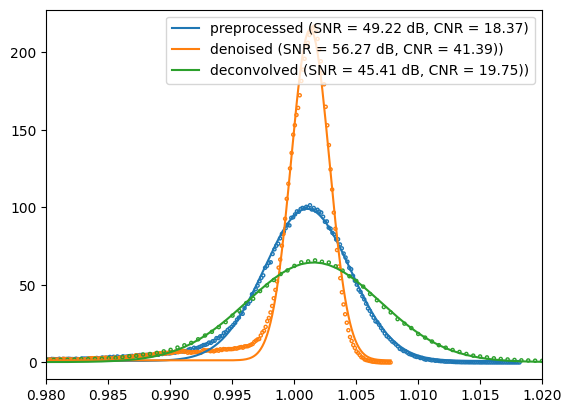

In [94]:
from scipy.optimize import curve_fit

bins_num = 1000

hist, bin_edges = np.histogram(obj_ROI, bins=bins_num, density=True)
bin_edges = (bin_edges[1:] + bin_edges[0:-1]) / 2
plt.scatter(bin_edges, hist, s=5, facecolors='none', edgecolors='C0')
# plt.hist(obj_ROI.flatten(), bins=bins_num, alpha=0.5, density=True, label="raw")

hist_den, bin_edges_den = np.histogram(obj_interp, bins=bins_num, density=True)
bin_edges_den = (bin_edges_den[1:] + bin_edges_den[0:-1]) / 2
plt.scatter(bin_edges_den, hist_den, s=5, facecolors='none', edgecolors='C1')
# plt.hist(obj_denoised.flatten(), bins=bins_num, alpha=0.5, density=True, label="denoised")

hist_dec, bin_edges_dec = np.histogram(obj_deconv, bins=bins_num, density=True)
bin_edges_dec = (bin_edges_dec[1:] + bin_edges_dec[0:-1]) / 2
plt.scatter(bin_edges_dec, hist_dec, s=5, facecolors='none', edgecolors='C2')
# plt.hist(obj_deconv.flatten(), bins=bins_num, alpha=0.5, density=True, label="deconvolved")

def fit_gaussian(x_data, y_data):
    """
    Аппроксимирует одномерные данные (x_data, y_data) Гауссовой функцией.

    Модель Гаусса: f(x) = A * exp(-(x - mu)^2 / (2 * sigma^2)) + C
    Где:
    - A: Амплитуда (высота пика) Гауссовой кривой, также может рассматриваться как фактор нормировки.
    - mu: Центр (среднее значение) Гауссовой кривой.
    - sigma: Ширина (стандартное отклонение) Гауссовой кривой.
    - C: Смещение (базовая линия).

    Параметры:
    x_data : numpy.ndarray
        Одномерный массив значений по оси X.
    y_data : numpy.ndarray
        Одномерный массив значений по оси Y, соответствующий x_data.

    Возвращает:
    numpy.ndarray
        Массив значений Y, представляющий аппроксимированную Гауссову кривую
        для заданных x_data и найденных параметров.
        Возвращает None, если аппроксимация не удалась.
    """

    # 1. Определяем Гауссову функцию
    # Смещение (offset) добавляется для учета ненулевой базовой линии
    def gaussian(x, amplitude, center, sigma, offset):
        return amplitude * np.exp(-(x - center)**2 / (2 * sigma**2)) + offset

    # 2. Предоставляем начальные догадки для параметров
    # Хорошие начальные догадки помогают curve_fit быстрее и правильнее сойтись.
    amplitude_guess = np.max(y_data) - np.min(y_data) # Примерная амплитуда пика
    center_guess = x_data[np.argmax(y_data)]         # X-координата максимального Y
    sigma_guess = (x_data[-1] - x_data[0]) / 100.0     # Примерная ширина (диапазон / 6)
    offset_guess = np.min(y_data)                     # Примерная базовая линия

    initial_guesses = [amplitude_guess, center_guess, sigma_guess, offset_guess]

    # Ограничения для параметров (опционально, но часто полезно)
    # Например, sigma должна быть положительной, амплитуда может быть положительной/отрицательной
    # center_guess в пределах x_data, offset_guess в пределах y_data
    # bounds = ([min_amplitude, min_center, min_sigma, min_offset],
    #           [max_amplitude, max_center, max_sigma, max_offset])
    # Для sigma точно надо, чтобы была > 0
    bounds = ([-np.inf, x_data.min(), 0.001, -np.inf], # Нижние границы
              [ np.inf, x_data.max(), np.inf,  np.inf]) # Верхние границы


    # 3. Выполняем аппроксимацию
    try:
        # popt - оптимальные параметры, pcov - ковариационная матрица
        popt, pcov = curve_fit(gaussian, x_data, y_data, p0=initial_guesses, bounds=bounds)
    except RuntimeError as e:
        print(f"Ошибка при аппроксимации Гауссовой функцией: {e}")
        print("Попробуйте скорректировать начальные параметры или данные.")
        return None

    # 4. Извлекаем аппроксимированные параметры
    amplitude_fit, center_fit, sigma_fit, offset_fit = popt

    # 5. Выводим параметры через print
    print("--- Параметры аппроксимации Гауссовой кривой ---")
    print(f"Амплитуда (A, фактор нормировки): {amplitude_fit:.4f}")
    print(f"Центр (mu):                      {center_fit:.4f}")
    print(f"Ширина (sigma, стандартное откл.):{sigma_fit:.4f}")
    print(f"Смещение (C, базовая линия):     {offset_fit:.4f}")
    print("--------------------------------------------------")

    # 6. Генерируем аппроксимированную кривую
    fitted_gaussian_curve = gaussian(x_data, *popt)

    return center_fit, sigma_fit, fitted_gaussian_curve

mu, sig, hist_approx = fit_gaussian(bin_edges, hist)
print(mu)
mu_den, sig_den, hist_den_approx = fit_gaussian(bin_edges_den, hist_den)
mu_dec, sig_dec, hist_dec_approx = fit_gaussian(bin_edges_dec, hist_dec)

CNR = (1 - 0.91) / np.sqrt(2 * sig**2)
CNR_den = (1 - 0.91) / np.sqrt(2 * sig_den**2)
CNR_dec = (1 - 0.85) / np.sqrt(2 * sig_dec**2)

def SNR(mu, sig):
    return 20*np.log10(mu/sig)

%matplotlib inline
plt.plot(bin_edges, hist_approx, label=f"preprocessed (SNR = {SNR(mu, sig):.2f} dB, CNR = {CNR:.2f})")
plt.plot(bin_edges_den, hist_den_approx, label=f"denoised (SNR = {SNR(mu_den, sig_den):.2f} dB, CNR = {CNR_den:.2f}))")
plt.plot(bin_edges_dec, hist_dec_approx, label=f"deconvolved (SNR = {SNR(mu_dec, sig_dec):.2f} dB, CNR = {CNR_dec:.2f}))")
plt.xlim(0.98, 1.02)
plt.legend()

### Validation of the image upscaling

### Uploading the numerical model image (res = 81.25 nm)

Text(0.5, 0.98, 'model (dot source)')

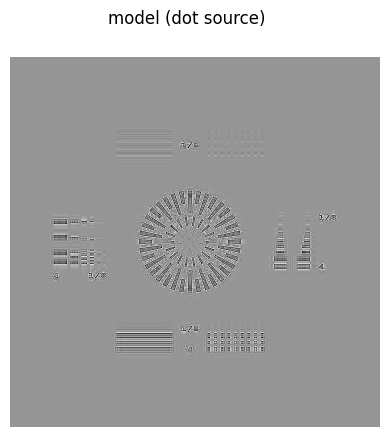

In [12]:
import numpy as np
import matplotlib.pyplot as plt
# obj_model = np.load("obj_model.npy")
# obj_model = np.load("SimStar_model_10.npy")
# obj_model = np.load("SimStar_target.npy")
obj_model = np.load("SimStar_model_dot.npy")
x_model = np.load("SimStar_x.npy")
y_model = np.load("SimStar_y.npy")
# SimStar_x, SimStar_y = np.meshgrid(SimStar_x, SimStar_y)
# plt.pcolormesh(SimStar_x, SimStar_y, obj_model)
obj_model /= obj_model[1378, 1438]
edge_idx = 200
obj_model[:edge_idx, :] = 1
obj_model[:, :edge_idx] = 1
obj_model[len(obj_model)-edge_idx:, :] = 1
obj_model[:, len(obj_model)-edge_idx:] = 1

%matplotlib inline
fig, ax = plt.subplots(1, 1)
plt.pcolormesh(obj_model, cmap="Greys_r")
ax.set_aspect('equal')
plt.axis("off")
fig.suptitle("model (dot source)")
# plt.savefig(f"target star.png", bbox_inches='tight', pad_inches=0, dpi=400)

### Bluring model image. Gaussian (long source) + OTF

In [13]:
def long_source(I_dot, z0, z1):
    # X, Y = np.meshgrid(x, y)
    sig_x = 1.03e-3/2.355 * z1/z0
    sig_y = 1.17e-4/2.355 * z1/z0
    # sig_y = 1.03e-3/2.355 * z1/z0
    fx = np.fft.fftfreq(len(I_dot), d=0.325e-6/4) * 2 * np.pi
    fy = np.fft.fftfreq(len(I_dot), d=0.325e-6/4) * 2 * np.pi
    fx, fy = np.meshgrid(fx, fy)
    source_fft = np.exp(- 0.5 * ((fx*sig_x)**2 + (fy*sig_y)**2))
    # plt.pcolormesh(fx, fy, source_fft)
    I_dot_fft = np.fft.fft2(I_dot)
    return np.fft.ifft2(I_dot_fft * source_fft).real

def blur_gauss(image, sig):
    fx = np.fft.fftfreq(len(image), d=0.325e-6/4) * 2 * np.pi
    fy = np.fft.fftfreq(len(image), d=0.325e-6/4) * 2 * np.pi
    fx, fy = np.meshgrid(fx, fy)
    source_fft = np.exp(- 0.5 * ((fx*sig)**2 + (fy*sig)**2))
    # plt.pcolormesh(fx, fy, source_fft)
    image_fft = np.fft.fft2(image)
    return np.fft.ifft2(image_fft * source_fft).real


obj_model_long = long_source(obj_model, z0=15, z1=8e-3)
# obj_model_long = blur_gauss(obj_model_long, 0.265e-6)


def blur_with_OTF(signal, dx=0.325/4):
    a, b = 4.05282672, 1.02456784
    # a, b = 0.5, 1
    # a, b = 0.9, 1
    fx = np.fft.fftfreq(len(signal), d=dx)
    fy = np.fft.fftfreq(len(signal), d=dx)
    fx, fy = np.meshgrid(fx, fy)
    f_rad = np.sqrt(fx**2+fy**2)
    OTF = np.exp(- a * (f_rad)**b)
    # OTF[f_rad>1/(0.325)] = 0
    # plt.pcolormesh(np.fft.fftshift(OTF))
    signal_fft = np.fft.fft2(signal)
    return np.fft.ifft2(signal_fft * OTF).real

obj_model_blured = blur_with_OTF(obj_model_long, 0.325/4)

### Averaging the 4x4 pixels to the 1x1 (from 81.25 nm to the nominal 0.325 mkm)

In [14]:
def avg_cells(array_2d):
  """
  Averages 4 neighboring cells in a 2D array, optimized using NumPy vectorization.

  Args:
    array_2d: A 2D NumPy array of shape (N, N), where N is guaranteed to be divisible by 4.

  Returns:
    A 2D NumPy array of shape (N/4, N/4), where each element is the average
    of 4 neighboring cells in the original array.
  """

  n = array_2d.shape[0]
  if n % 4 != 0:
    raise ValueError("The dimension of the array must be divisible by 4.")

  # Шаг 1: Изменяем форму массива для группировки блоков 4x4
  # Исходный массив (N, N)
  # Превращаем его в (N/4, 4, N/4, 4)
  # Это создает массив, где:
  # - первое измерение (N/4) представляет блоки строк
  # - второе измерение (4) представляет 4 строки внутри каждого блока
  # - третье измерение (N/4) представляет блоки столбцов
  # - четвертое измерение (4) представляет 4 столбца внутри каждого блока
  reshaped_array = array_2d.reshape(n // 4, 4, n // 4, 4)

  # Шаг 2: Вычисляем среднее значение по осям 1 и 3
  # (т.е. по внутренним 4 строкам и внутренним 4 столбцам каждого блока)
  new_array = reshaped_array.mean(axis=(1, 3))

  return new_array

_, _, obj_model_c = cutter(avg_cells(obj_model), 512, 512, 420)
_, _, obj_model_long_c = cutter(avg_cells(obj_model_long), 512, 512, 420)
_, _, obj_model_blured_c = cutter(avg_cells(obj_model_blured), 512, 512, 420)

# SimStar_blured_c = blur_with_OTF(SimStar_long_c, 0.325)

# _, _, SimStar_target_c = cutter(SimStar_target, 512*4, 512*4, 420*4)

### Alignment of experimental and model images

[[ 0.    0.  ]
 [16.11 11.93]
 [16.08 11.92]
 [16.08 11.92]]


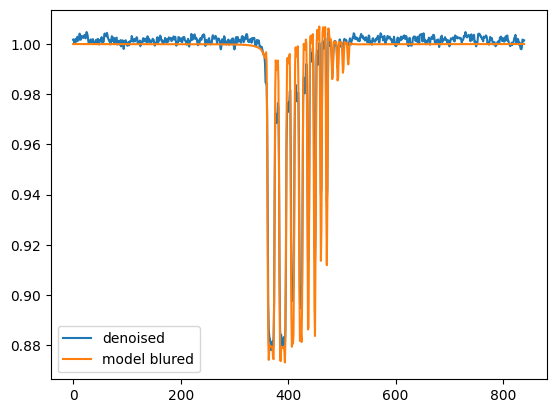

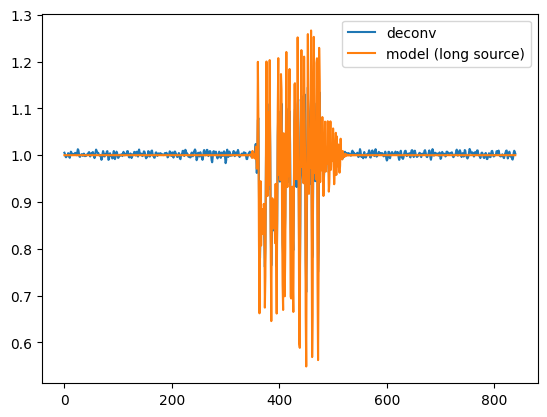

In [15]:
from scipy.ndimage import fourier_shift
from skimage.registration import phase_cross_correlation

def align_subpixel(frames):
    """
    Выравнивает 3D массив кадров (t, y, x) относительно первого кадра (frames[0]).
    Использует фазовую корреляцию с субпиксельной точностью.
    
    Parameters
    ----------
    frames : np.ndarray
        3D numpy массив формы (n_frames, height, width)
    
    Returns
    -------
    aligned : np.ndarray
        3D массив тех же размеров, где все кадры выравнены относительно нулевого.
    shifts : np.ndarray
        Массив рассчитанных сдвигов [dy, dx] для каждого кадра.
    """
    n_frames, h, w = frames.shape
    ref = frames[0]
    aligned = np.zeros_like(frames)
    aligned[0] = ref
    shifts = np.zeros((n_frames, 2))

    for i in range(1, n_frames):
        shift, error, diffphase = phase_cross_correlation(
            ref, frames[i], upsample_factor=100  # upsample_factor задаёт точность, 100 ≈ 0.01 пикселя
        )
        shifts[i] = shift
        # применяем сдвиг во фурье-области (корректный способ для субпиксельных смещений)
        shifted_fft = fourier_shift(np.fft.fftn(frames[i]), shift)
        aligned[i] = np.fft.ifftn(shifted_fft).real

    return aligned, shifts

obj_shift, shifts = align_subpixel(np.array([obj_denoised, obj_model_blured_c, obj_model_long_c, obj_model_c]))
print(shifts)

idx = 667
# idx = 238
_, obj_model_blured_a, obj_model_long_a, obj_model_a = obj_shift
plt.plot(obj_denoised[:, idx], label="denoised")
plt.plot(obj_model_blured_a[:, idx], label="model blured")
plt.legend()
plt.show()

plt.plot(obj_deconv[:, idx], label="deconv")
plt.plot(obj_model_long_a[:, idx], label="model (long source)")
# plt.plot(obj_model_a[:, idx], label="model (dot source)")
plt.legend()

### Estimation of the residual blur

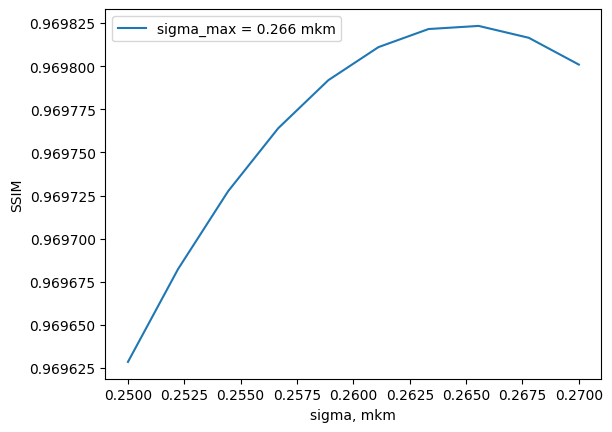

In [ ]:
from skimage.metrics import structural_similarity as ssim_metric

N = 10
sig_arr = np.linspace(0.25e-6, 0.27e-6, N)
# sig_arr = np.linspace(0.264e-6, 0.266e-6, N)
ssim_score = np.zeros(N)
for i, sig in enumerate(sig_arr):
    SimStar_blured = blur_gauss(obj_model_long, sig)
    _, _, SimStar_blured_c = cutter(avg_cells(SimStar_blured), 512, 512, 420)
    obj_shift, shifts = align_subpixel(np.array([obj_deconv, SimStar_blured_c]))
    ssim_score[i] = ssim_metric(obj_shift[0]/np.max(obj_shift[0]), obj_shift[1]/np.max(obj_shift[1]), data_range=1)

%matplotlib inline
plt.plot(sig_arr*1e6, ssim_score, label=f"sigma_max = {sig_arr[np.argmax(ssim_score)]*1e6:.3f} mkm")
plt.ylabel("SSIM")
plt.xlabel("sigma, mkm")
plt.legend()

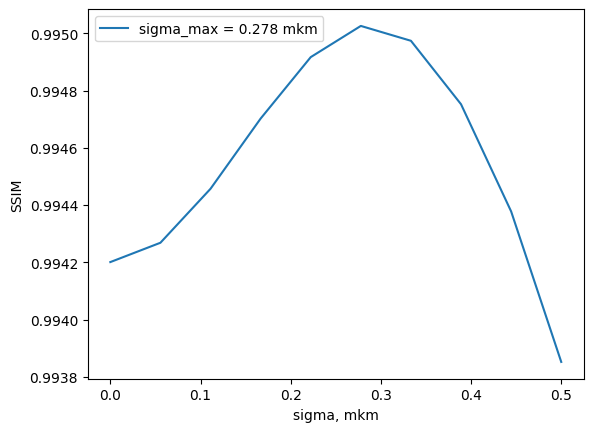

In [ ]:
N = 10
sig_arr = np.linspace(0e-6, 0.5e-6, N)
# sig_arr = np.linspace(0.264e-6, 0.266e-6, N)
ssim_score = np.zeros(N)
for i, sig in enumerate(sig_arr):
    SimStar_blured = blur_gauss(obj_model_blured, sig)
    _, _, SimStar_blured_c = cutter(avg_cells(SimStar_blured), 512, 512, 420)
    obj_shift, shifts = align_subpixel(np.array([obj_denoised, SimStar_blured_c]))
    ssim_score[i] = ssim_metric(obj_shift[0]/np.max(obj_shift[0]), obj_shift[1]/np.max(obj_shift[1]), data_range=1)

%matplotlib inline
plt.plot(sig_arr*1e6, ssim_score, label=f"sigma_max = {sig_arr[np.argmax(ssim_score)]*1e6:.3f} mkm")
plt.title()
plt.ylabel("SSIM")
plt.xlabel("sigma, mkm")
plt.legend()

### Residual blur (Gaussian)

In [90]:
SimStar_blured = blur_gauss(obj_model_long, 0.27e-6)
_, _, SimStar_blured_c = cutter(avg_cells(SimStar_blured), 512, 512, 420)
obj_shift, shifts = align_subpixel(np.array([obj_deconv, SimStar_blured_c]))
ssim_score[i] = ssim_metric(obj_shift[0]/np.max(obj_shift[0]), obj_shift[1]/np.max(obj_shift[1]), data_range=1)

obj_model_long_gauss_blur_sq = obj_shift[1][125:220, 460:555]
obj_model_long_gauss_blur_noised_sq = obj_model_long_gauss_blur_sq + np.random.normal(0, sig_dec, size=obj_model_long_gauss_blur_sq.shape)


SimStar_blured = blur_gauss(obj_model_blured, 0.27e-6)
_, _, SimStar_blured_c = cutter(avg_cells(SimStar_blured), 512, 512, 420)
obj_shift, shifts = align_subpixel(np.array([obj_denoised, SimStar_blured_c]))

obj_model_2_blur_sq = obj_shift[1][125:220, 460:555]
obj_model_2_blur_noised_sq = obj_model_2_blur_sq + np.random.normal(0, sig_den, size=obj_model_2_blur_sq.shape)

### Comparison of experimental data with simulation results

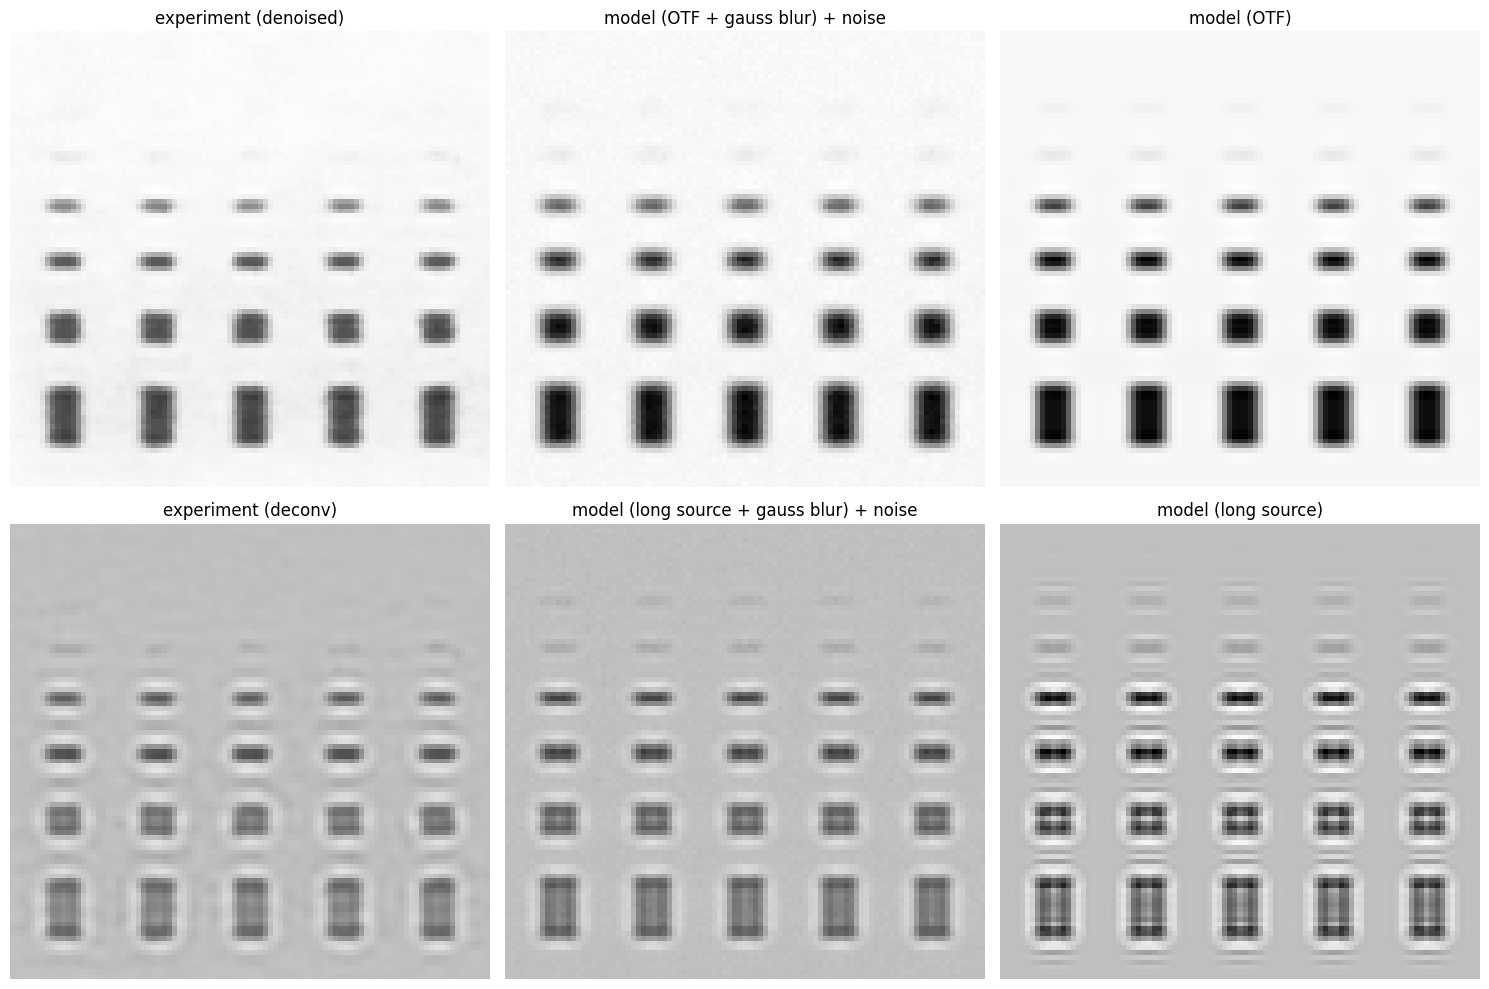

In [88]:
obj_model_long_sq = obj_model_long_a[125:220, 460:555]
obj_model_blured_sq = obj_model_blured_a[125:220, 460:555]

obj_denoised_sq = obj_denoised[125:220, 460:555]
obj_deconv_sq = obj_deconv[125:220, 460:555]

%matplotlib inline
# fig, ax = plt.subplots(1, 1)

x_y = np.linspace(-94//2*0.325, 95//2*0.325, 95)


fig, ax = plt.subplots(2, 3, figsize=(15, 10))

ax[0, 0].pcolormesh(x_y, x_y, obj_denoised_sq, cmap="Greys_r",
                    vmin=np.min([obj_model_blured_sq, obj_denoised_sq, obj_model_2_blur_noised_sq]),
                    vmax=np.max([obj_model_blured_sq, obj_denoised_sq, obj_model_2_blur_noised_sq]))
ax[0, 0].axis("off")
ax[0, 0].set_title("experiment (denoised)")

ax[0, 1].pcolormesh(x_y, x_y, obj_model_2_blur_noised_sq,  cmap="Greys_r",
                    vmin=np.min([obj_model_blured_sq, obj_denoised_sq, obj_model_2_blur_noised_sq]),
                    vmax=np.max([obj_model_blured_sq, obj_denoised_sq, obj_model_2_blur_noised_sq]))
ax[0, 1].axis("off")
ax[0, 1].set_title("model (OTF + gauss blur) + noise")

ax[0, 2].pcolormesh(x_y, x_y, obj_model_blured_sq,  cmap="Greys_r",
                    vmin=np.min([obj_model_blured_sq, obj_denoised_sq, obj_model_2_blur_noised_sq]),
                    vmax=np.max([obj_model_blured_sq, obj_denoised_sq, obj_model_2_blur_noised_sq]))
ax[0, 2].axis("off")
ax[0, 2].set_title("model (OTF)")

ax[1, 0].pcolormesh(x_y, x_y, obj_deconv_sq, cmap="Greys_r",
                    vmin=np.min([obj_model_long_sq, obj_deconv_sq, obj_model_long_gauss_blur_noised_sq]),
                    vmax=np.max([obj_model_long_sq, obj_deconv_sq, obj_model_long_gauss_blur_noised_sq]))
ax[1, 0].axis("off")
ax[1, 0].set_title("experiment (deconv)")


ax[1, 1].pcolormesh(x_y, x_y, obj_model_long_gauss_blur_noised_sq, cmap="Greys_r",
                    vmin=np.min([obj_model_long_sq, obj_deconv_sq, obj_model_long_gauss_blur_noised_sq]),
                    vmax=np.max([obj_model_long_sq, obj_deconv_sq, obj_model_long_gauss_blur_noised_sq]))
ax[1, 1].axis("off")
ax[1, 1].set_title("model (long source + gauss blur) + noise")


ax[1, 2].pcolormesh(x_y, x_y, obj_model_long_sq, cmap="Greys_r",
                    vmin=np.min([obj_model_long_sq, obj_deconv_sq, obj_model_long_gauss_blur_noised_sq]),
                    vmax=np.max([obj_model_long_sq, obj_deconv_sq, obj_model_long_gauss_blur_noised_sq]))
ax[1, 2].axis("off")
ax[1, 2].set_title("model (long source)")

plt.tight_layout()
plt.show()


# plt.pcolormesh(x_y, x_y, obj_model_blured_sq, cmap="Greys_r", vmin=np.min([obj_model_blured_sq, obj_denoised_sq]), vmax=np.max([obj_model_blured_sq, obj_denoised_sq]))
# plt.pcolormesh(x_y, x_y, obj_denoised_sq, cmap="Greys_r", vmin=np.min([obj_model_blured_sq, obj_denoised_sq]), vmax=np.max([obj_model_blured_sq, obj_denoised_sq]))

# plt.pcolormesh(x_y, x_y, obj_model_long_sq, cmap="Greys_r", vmin=np.min([obj_model_long_sq, obj_deconv_sq]), vmax=np.max([obj_model_long_sq, obj_deconv_sq]))
# plt.pcolormesh(x_y, x_y, obj_deconv_sq, cmap="Greys_r",  vmin=np.min([obj_model_long_sq, obj_deconv_sq]), vmax=np.max([obj_model_long_sq, obj_deconv_sq]))

# plt.xlim(-15, 15)
# plt.ylim(-15, 15)
# ax.set_aspect('equal')
# plt.axis("off")
# plt.colorbar(c, location="bottom")
# plt.savefig("pics_OTF/denoised.png", bbox_inches='tight', pad_inches=0, dpi=400)
# fig.suptitle("target star")

Text(0, 0.5, 'Intensity, arb. un.')

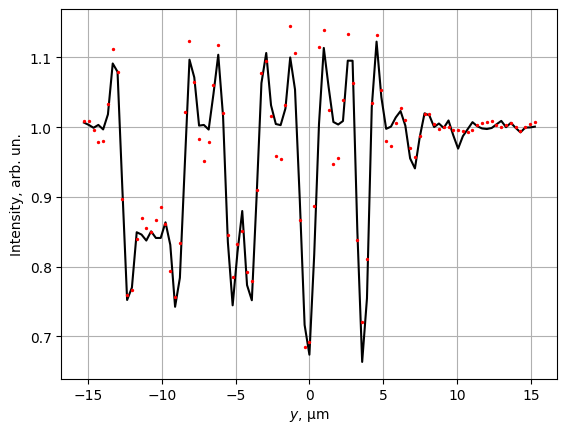

In [97]:
# fig, ax = plt.subplots(1, 1)

# plt.figure(figsize=(4, 2.5), dpi=400)
plt.figure()
plt.grid(zorder=0)

# plt.plot(x_y, obj_model_blured_sq[:, 95//2], c="k", zorder=2)
# plt.plot(x_y, obj_model_2_blur_noised_sq[:, 95//2], c="k", zorder=2)
# plt.scatter(x_y, obj_denoised_sq[:, 95//2], s=2, c="r",  zorder=3)


# plt.plot(x_y, obj_model_long_sq[:, 95//2], c="k", zorder=2)
plt.plot(x_y, obj_model_long_gauss_blur_noised_sq[:, 95//2], c="k", zorder=2)
plt.scatter(x_y, obj_deconv_sq[:, 95//2], s=2, c="r", zorder=3)

# plt.plot(x_y, obj_model_blured[:, 95//2])


# plt.legend()
# plt.ylim(0.6, 1.3)

# plt.xlabel(f"$y$, мкм")
# plt.ylabel(f"Интенсивность, отн. ед.")

plt.xlabel(f"$y$, µm")
plt.ylabel(f"Intensity, arb. un.")